In [1]:
library(igraph)
library(FNN)
# KNN+Lovain

# PCA
pca.norm = prcomp(data.norm)
info.norm %<>% cbind(pca.norm$x[, 1:2])
ggplot(info.norm, aes(x = PC1, y = PC2, colour = truth)) + geom_point(alpha = 0.3) + theme_bw()
# TSNE
library(Rtsne)
tsne.norm = Rtsne(pca.norm$x, pca = FALSE)
info.norm %<>% mutate(tsne1 = tsne.norm$Y[, 1], tsne2 = tsne.norm$Y[, 2])
ggplot(info.norm, aes(x = tsne1, y = tsne2, colour = truth)) + geom_point(alpha = 0.3) + theme_bw()


k = 100
knn.norm = get.knn(as.matrix(tsne.norm$Y), k = k)
knn.norm = data.frame(from = rep(1:nrow(knn.norm$nn.index), k), to = as.vector(knn.norm$nn.index), weight = 1/(1 + as.vector(knn.norm$nn.dist)))
nw.norm = graph_from_data_frame(knn.norm, directed = FALSE)
nw.norm = simplify(nw.norm)
lc.norm = cluster_louvain(nw.norm)
info.norm$louvain = as.factor(membership(lc.norm))
lc.cent = info.norm %>% group_by(louvain) %>% select(tsne1, tsne2) %>% summarize_all(mean)
ggplot(info.norm, aes(x = tsne1, y = tsne2, colour = louvain)) + 
    geom_point(alpha = 0.3) + theme_bw() + geom_label_repel(aes(label = louvain), 
    data = lc.cent) + guides(colour = FALSE)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘FNN’

The following object is masked from ‘package:igraph’:

    knn



In [85]:
library(Seurat)

In [8]:
library('hdf5r')

In [9]:
rna=ReadH5AD('SNARE-seq/cellline/rn.h5ad')

Pulling expression matrices and metadata
Data is scaled


ERROR: Error in ReadH5AD.H5File(file = hfile, assay = assay, verbose = verbose): Seurat requires normalized data present in the raw slot when X is scaled


In [14]:
cellline.data <- read.csv(file = "/home/xionglei/yanqiu/datasets/SNARE-seq/CellLineMixture//RNA/GSE126074_CellLineMixture_SNAREseq_cDNA_counts.tsv.gz", 
                          row.names = 1,sep='\t')

In [17]:
seuset <- CreateSeuratObject(
  counts = cellline.data,
  assay = "RNA",
  min.cells = 10,
  min.features = 100
)

In [18]:
seuset <- NormalizeData(object = seuset,  normalization.method = "LogNormalize", scale.factor = 10000)

In [22]:
seuset <- FindVariableFeatures(object = seuset,selection.method = "vst", nfeatures = 3000)

In [24]:
all.genes <- rownames(seuset)
seuset <- ScaleData(seuset, features = all.genes)
# Perform linear dimensional reduction
seuset <- RunPCA(seuset, features = VariableFeatures(object = seuset))

Centering and scaling data matrix


PC_ 1 
Positive:  TERF1, RP11-148B6.1, ESRG, GRID2, CD24, EPCAM, SNHG1, HSPD1, NOP56, L1TD1 
	   APOE, RP11-415G4.1, SFRP2, RP11-69I8.2, AASS, PRAME, TRDN, CTD-2306M5.1, CD74, NMU 
	   DNMT3B, TDGF1, XIST, RP11-267L5.1, EZH2, HLA-DRB1, XACT, MS4A1, DPPA4, GAL 
Negative:  COL1A2, IGFBP7, DCN, LUM, THBS1, FN1, COL1A1, TNFRSF11B, SPARC, COL6A3 
	   IGFBP3, C1S, CEMIP, FBLN1, ANXA2, CTSB, SULF1, COL3A1, FBLN5, THBS2 
	   IFITM3, FSTL1, SERPINE2, VIM, TIMP3, CTSK, C1R, PTRF, EFEMP1, IGFBP6 
PC_ 2 
Positive:  HLA-DRA, HLA-DRB1, MS4A1, CD74, B2M, HLA-DPA1, SRGN, HLA-DQB1, SLAMF1, CD48 
	   HLA-B, XIST, RGS1, DNASE1L3, ID2, HLA-DQA1, TMSB4X, FNBP1, HLA-DPB1, CCR7 
	   IGHM, BCL2A1, SAT1, MIR155HG, FCER2, GADD45B, CD274, MAP7D2, BIRC3, HLA-F 
Negative:  TERF1, RP11-148B6.1, GRID2, ESRG, APOE, NOP56, CD24, VCAN, RP11-415G4.1, L1TD1 
	   EPCAM, SFRP2, CTD-2306M5.1, AASS, HSPD1, RP11-69I8.2, SFRP1, TDGF1, RP11-267L5.1, DPPA4 
	   SNHG14, RARRES2, TRDN, UNC5D, DNMT3B, SLC7A3, PTPRZ1, RP11-1144P22.1

In [25]:
#Cluster the cells
seuset <- FindNeighbors(seuset, dims = 1:10)
seuset <- FindClusters(seuset, resolution = 0.5)

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1047
Number of edges: 38718

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8653
Number of communities: 5
Elapsed time: 0 seconds


In [29]:
# Look at cluster IDs of the first 5 cells
head(Idents(seuset),5)

ACTTTCTAATCA GAGAGAAAACCT TACGGCTGTTAT GACGCGTAAGTG GAAAGGACTGCA 
           0            2            2            0            0 
Levels: 0 1 2 3 4

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”

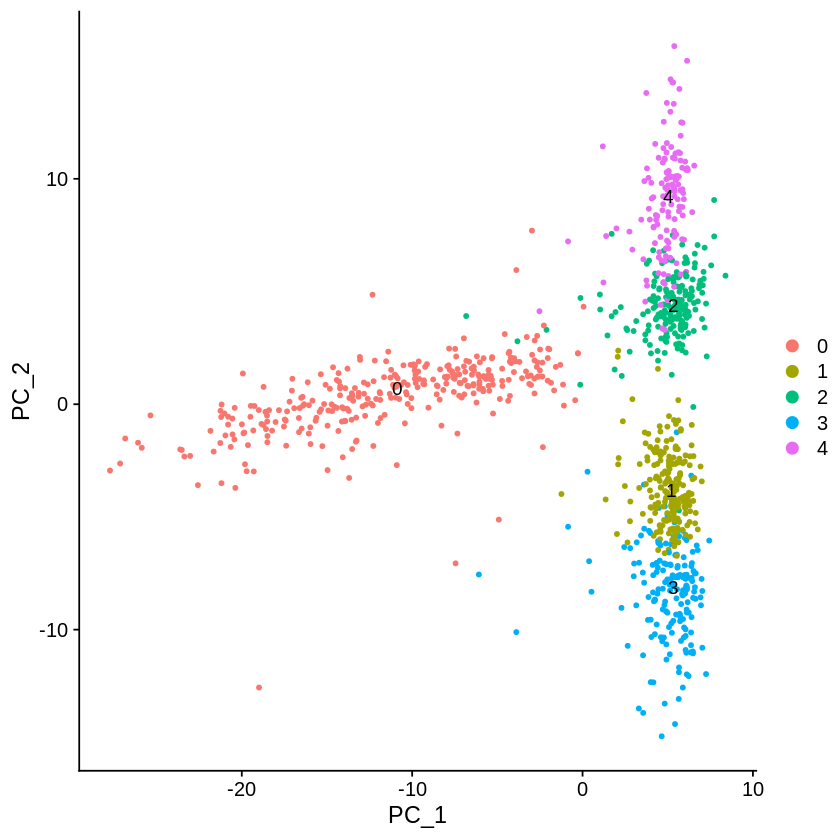

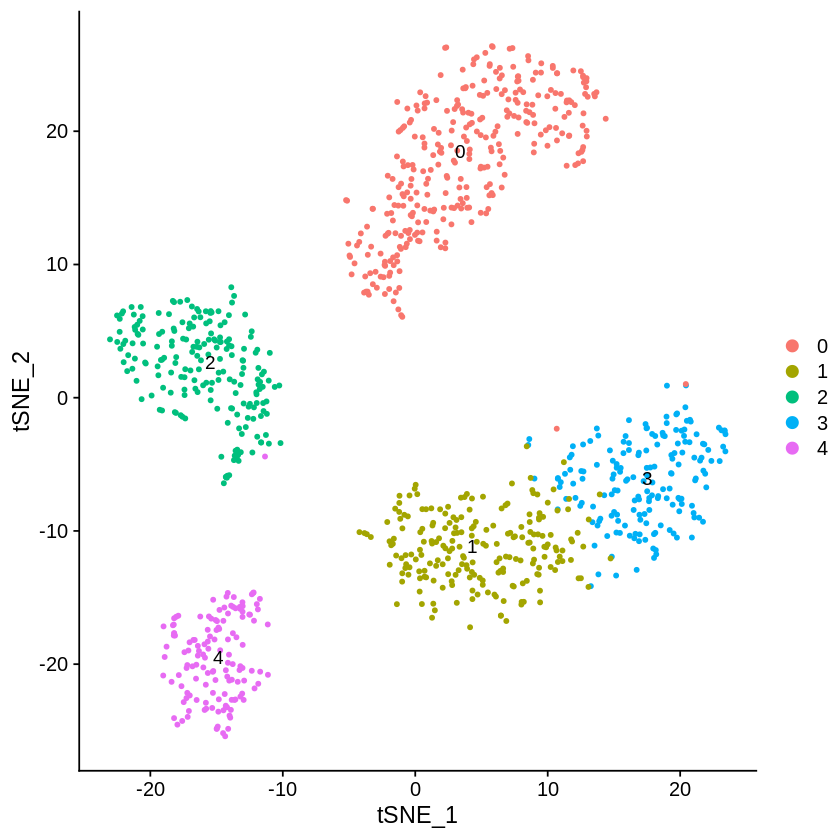

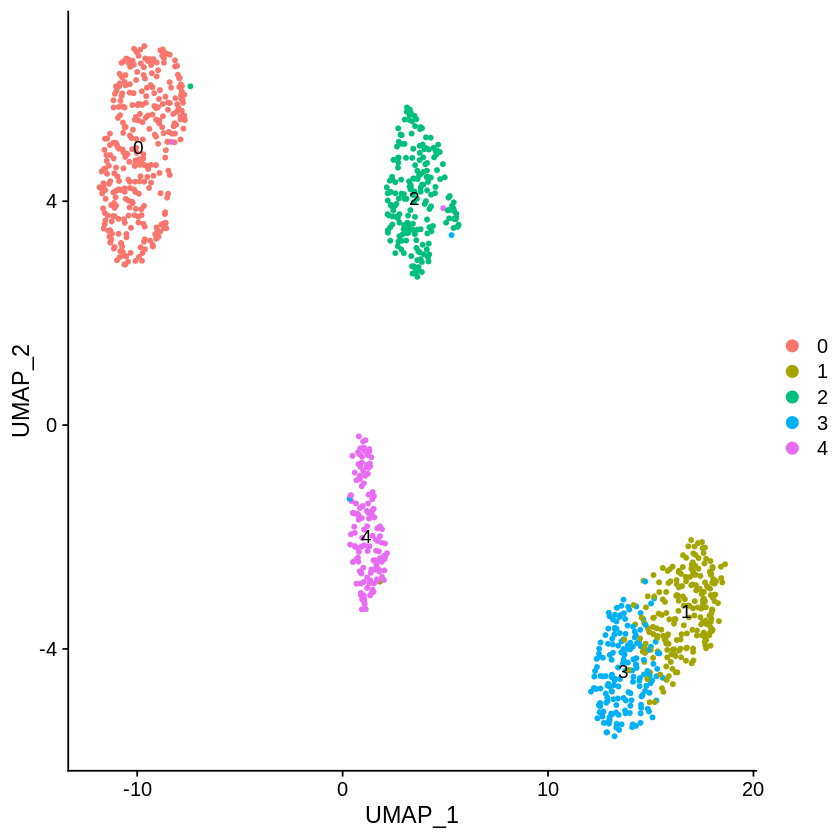

In [30]:
DimPlot(seuset, reduction = "pca",label = TRUE)

# Run non-linear dimensional reduction (UMAP/tSNE)
#reticulate::py_install(packages = 'umap-learn')
seuset <- RunTSNE(seuset, dims = 1:10)
seuset <- RunUMAP(seuset, dims = 1:10)

# note that you can set `label = TRUE` or use the LabelClusters function to help label individual clusters
DimPlot(seuset, reduction = "tsne",label = TRUE)
DimPlot(seuset, reduction = "umap",label = TRUE)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1047
Number of edges: 38718

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.1103
Number of communities: 120
Elapsed time: 0 seconds


17 singletons identified. 103 final clusters.


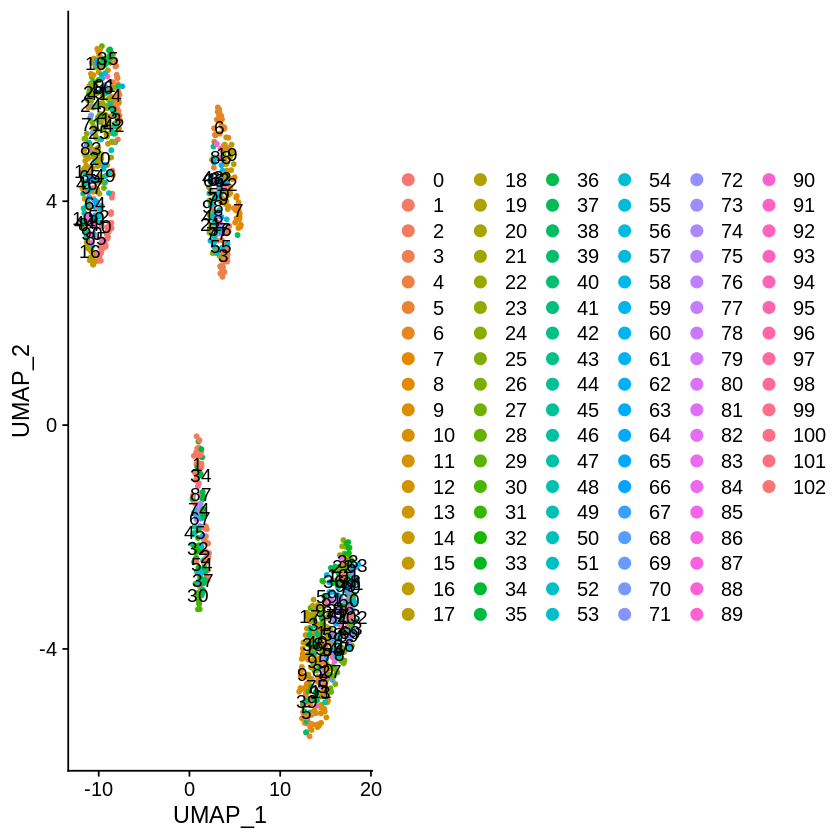

In [48]:
seuset <- FindClusters(seuset, resolution = 15)
DimPlot(seuset, reduction = "umap",label = TRUE)

In [38]:
WriteH5AD(seuset, 'SNARE-seq//cellline/rn_seurat.h5ad', assay = NULL, graph = NULL,verbose = TRUE, overwrite = FALSE)

ERROR: Error in WriteH5AD(seuset, "SNARE-seq//cellline/an_seurat.h5ad", assay = NULL, : could not find function "WriteH5AD"


In [42]:
pfile <- Convert(from = seuset, to = "loom", filename = "SNARE-seq//cellline/an_seurat.loom", display.progress = FALSE)

ERROR: Error in Convert(from = seuset, to = "loom", filename = "SNARE-seq//cellline/an_seurat.loom", : could not find function "Convert"


In [55]:
as.loom(seuset, assay = 'RNA', filename = 'SNARE-seq//cellline/an_seurat.loom', chunk.dims = NULL, chunk.size = NULL, overwrite = FALSE, verbose = TRUE)

Transposing input data: loom file will show input columns (cells) as rows and input rows (features) as columns
This is to maintain compatibility with other loom tools


  |======================================================================| 100%


Adding: CellID
Adding: Gene
Adding a layer to norm_data (layer 1 of 1)


  |======================================================================| 100%


Adding: vst_mean
Adding: vst_variance
Adding: vst_variance_expected
Adding: vst_variance_standardized
Adding: vst_variable
Adding: Selected
Adding: orig_ident
Adding: nCount_RNA
Adding: nFeature_RNA
Adding: RNA_snn_res_0_5
Adding: seurat_clusters
Adding: RNA_snn_res_1_5
Adding: RNA_snn_res_5
Adding: RNA_snn_res_10
Adding: RNA_snn_res_20
Adding: RNA_snn_res_15
Adding: ClusterID
Adding: ClusterName
Adding scaled data matrix to /layers/scale_data
Adding a layer to scale_data (layer 1 of 1)


  |======================================================================| 100%


Adding dimensional reduction information for pca
Adding cell embedding information for pca
Adding feature loading information for pca
Adding dimensional reduction information for tsne
Adding cell embedding information for tsne
No feature loading information for tsne
Adding dimensional reduction information for umap
Adding cell embedding information for umap
No feature loading information for umap
Adding graph RNA_nn
Adding graph RNA_snn


Class: loom
Filename: /data01/yanqiu/regulatory/SNARE-seq/cellline/an_seurat.loom
Access type: H5F_ACC_RDWR
Attributes: version, chunks, LOOM_SPEC_VERSION, assay, last_modified
Listing:
       name    obj_type dataset.dims dataset.type_class
  col_attrs   H5I_GROUP         <NA>               <NA>
 col_graphs   H5I_GROUP         <NA>               <NA>
     layers   H5I_GROUP         <NA>               <NA>
     matrix H5I_DATASET  1047 x 9266          H5T_FLOAT
  row_attrs   H5I_GROUP         <NA>               <NA>
 row_graphs   H5I_GROUP         <NA>               <NA>

In [45]:
lfile <- connect(filename = "SNARE-seq//cellline/rn_seurat.loom", mode = "r+")

ERROR: Error in connect(filename = "SNARE-seq//cellline/rn_seurat.loom", mode = "r+"): unused argument (filename = "SNARE-seq//cellline/rn_seurat.loom")


In [37]:
packageVersion("Seurat")

[1] ‘3.0.2’